In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200
        
name = 'mvi'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [2]:
import re
import torch
import numpy as np
import pickle 
import json
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import matplotlib.pyplot as plt
import seaborn as sns

from nnsysident.training.trainers import standard_trainer as poisson_trainer
from nnsysident.models.models import se2d_fullgaussian2d as poisson_se2d_fullgaussian2d
from neuralmetrics.utils import extract_data_key
# from neuralmetrics.models.direct import ZIG
# from neuralmetrics.training.losses import ZIGLoss
from neuralmetrics.training.trainers import nn_zig_trainer
from neuralmetrics.datasets import static_loaders
from neuralmetrics.models.neuralnet import zig_se2d_fullgaussian2d
from neuralpredictors.measures import corr
from scipy.stats import spearmanr, pearsonr

from dataport.bcm.static import PreprocessedMouseData

random_seed = 27121992
device = 'cuda'

Connecting konstantin@134.76.19.44:3306


---

In [3]:
datasets =  [{'animal_id': 26614,
              'session': 1,
              'scan_idx': 16,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26614,
              'session': 2,
              'scan_idx': 17,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26726,
              'session': 6,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26726,
              'session': 7,
              'scan_idx': 13,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26942,
              'session': 1,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26942,
              'session': 2,
              'scan_idx': 8,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 27468,
              'session': 3,
              'scan_idx': 12,
              'scan_purpose': 'imagenet'},
             {'animal_id': 27468,
              'session': 4,
              'scan_idx': 7,
              'scan_purpose': 'dei_control_pair'}]

## Imagenet Data

In [4]:
imagenet_key = datasets[0]
assert imagenet_key["scan_purpose"] == "imagenet"
paths = ["./data/static{}-{}-{}-GrayImageNet-7bed7f7379d99271be5d144e5e59a8e7.zip".format(imagenet_key["animal_id"], imagenet_key["session"], imagenet_key["scan_idx"])]
img_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'loader_outputs': ["images", "responses"],
                  'normalize': True,
                  'exclude': ["images"]
                  }
    
img_dataloaders = static_loaders(**dataset_config)
img_dataset = img_dataloaders["test"][img_data_key].dataset

---

## Models

### ZIG

In [5]:
loc = np.exp(-10)

zig_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "feature_reg_weight": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},
    'zero_thresholds': {img_data_key: loc},

    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "k_image_dependent": True,
}


zig_model = zig_se2d_fullgaussian2d(img_dataloaders, random_seed, **zig_model_config)
zig_model.to(device);

/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


In [ ]:
score, output, state_dict = nn_zig_trainer(zig_model,
                                           img_dataloaders,
                                           random_seed, 
                                           loss_function="ZIGLoss", 
                                           stop_function="get_loss", 
                                           track_training=True, 
                                           maximize=False)
zig_model.eval();
# torch.save(state_dict, "ZIG_statedict" + img_data_key)


# zig_model.load_state_dict(torch.load("ZIG_statedict" + img_data_key))
# zig_model.eval();

### Poisson

In [ ]:
poisson_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "gamma_readout": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},
    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
}


poisson_model = poisson_se2d_fullgaussian2d(img_dataloaders, random_seed, **poisson_model_config)
poisson_model.to(device);

In [ ]:
score, output, state_dict = poisson_trainer(poisson_model,
                                           img_dataloaders,
                                           random_seed,)
poisson_model.eval();
torch.save(state_dict, "Poisson_statedict" + img_data_key + '.inshallah')


# poisson_model.load_state_dict(torch.load("Poisson_statedict" + img_data_key + '.inshallah'))
# poisson_model.eval();

---

# Train Model

___

### DEI data

In [7]:
idx = np.array([(dat["animal_id"] == imagenet_key["animal_id"]) & (dat["session"] != imagenet_key["session"]) & (dat["scan_idx"] != imagenet_key["scan_idx"]) for dat in datasets])
dei_key = np.array(datasets)[idx].item()

assert dei_key["scan_purpose"] == "dei_control_pair"
paths = ["./data/static{}-{}-{}-GrayImageNetDEIInfo-7bed7f7379d99271be5d144e5e59a8e7.zip".format(dei_key["animal_id"], dei_key["session"], dei_key["scan_idx"])]
dei_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'return_test_sampler': True,
                  'tier': "test",
                  'loader_outputs': ["images", 'responses', 'trial_idx', "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances"],
                  'normalize': True,
                  'exclude': ["images", "trial_idx", "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances"]}

dei_dataloaders = static_loaders(**dataset_config)

dei_dataset = dei_dataloaders["test"][dei_data_key].dataset

Returning only test sampler with repeats...


In [8]:
images, responses, trial_idxs, dei_unit_ids, dei_src_unit_ids, dei_mean_distances = [], [], [], [], [], []
for image, response, trial_idx, dei_unit_id, dei_src_unit_id, dei_mean_distance in dei_dataloaders["test"][dei_data_key]:
    if (len(response) == 20) & (torch.unique(dei_mean_distance <= 10)):
        images.append(image)
        responses.append(response)
        trial_idxs.append(trial_idx)
        dei_unit_ids.append(dei_unit_id)
        dei_src_unit_ids.append(dei_src_unit_id)
        dei_mean_distances.append(dei_mean_distance)
images = torch.stack(images)
responses = torch.stack(responses)
trial_idxs = torch.stack(trial_idxs).cpu().data.numpy()
dei_unit_ids = torch.stack(dei_unit_ids).cpu().data.numpy()
dei_src_unit_ids = torch.stack(dei_src_unit_ids).cpu().data.numpy()
dei_mean_distances = torch.stack(dei_mean_distances).cpu().data.numpy()

In [9]:
# Get possible unit ids (in the source-dataset frame)
possible_src_unit_ids = np.unique(dei_src_unit_ids, axis=1).squeeze()

# Sort according to mean distances (increasing)
src_sort_idx = np.argsort(np.unique(dei_mean_distances, axis=1).squeeze())
possible_src_unit_ids = possible_src_unit_ids[src_sort_idx]

# Remove duplicates (from several DEIs/MEI)
_, idx = np.unique(possible_src_unit_ids, return_index=True)
possible_src_unit_ids = possible_src_unit_ids[np.sort(idx)]

In [10]:
zig_means = np.full((3, len(possible_src_unit_ids)), np.nan)
zig_variances = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_means = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_vars = np.full((3, len(possible_src_unit_ids)), np.nan)
imgs = np.full((3, len(possible_src_unit_ids), 1, 36, 64), np.nan)
for i, possible_src_unit_id in enumerate(possible_src_unit_ids):
    image_idx = np.unique(np.where(dei_src_unit_ids == possible_src_unit_id)[0])

    dei_neuron_id = np.unique(dei_unit_ids[image_idx]).item()
    src_neuron_id = np.unique(dei_src_unit_ids[image_idx]).item()
    src_neuron_idx = np.where(img_dataset.neurons.unit_ids == src_neuron_id)[0].item()
    dei_neuron_idx = np.where(dei_dataset.neurons.unit_ids == dei_neuron_id)[0].item()

    img = torch.unique(images[image_idx], dim=1).squeeze(1)
    mei_dei_idx = [0, 1, 2]
    if len(image_idx) != 3:
        idx = np.where(np.isin(dei_dataset.trial_info.trial_idx, trial_idxs[image_idx]))[0]
        if 'mask_fixed_mei' in np.unique(dei_dataset.trial_info.frame_image_class[idx]):
            mei_dei_idx = [0, 1] if len(image_idx) == 2 else [0]
        else:
            mei_dei_idx = [1, 2] if len(image_idx) == 2 else [1]
    imgs[mei_dei_idx, i, :, :, :] = img.cpu().data
    
    # TODO: Keep this line?
#     img = torch.stack([((im - im.mean()) / (im.std())) for im in img.squeeze()])[:, None]

    
    zig_means_ = zig_model.predict_mean(img, data_key=img_data_key).cpu().data.numpy()
    zig_variances_ = zig_model.predict_variance(img, data_key=img_data_key).cpu().data.numpy()

    zig_means[mei_dei_idx, i] = zig_means_[:, src_neuron_idx]
    zig_variances[mei_dei_idx, i] = zig_variances_[:, src_neuron_idx]
    
    real_resp_means[mei_dei_idx, i] = np.mean(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
    real_resp_vars[mei_dei_idx, i] = np.var(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
keep_idx = ~np.isnan(zig_means).any(axis=0)

### Compare Zhiwei Model with Konstantin model

In [15]:
with open(r"group233_mei_dei_resps.pkl", "rb") as input_file:
    e = pickle.load(input_file).T

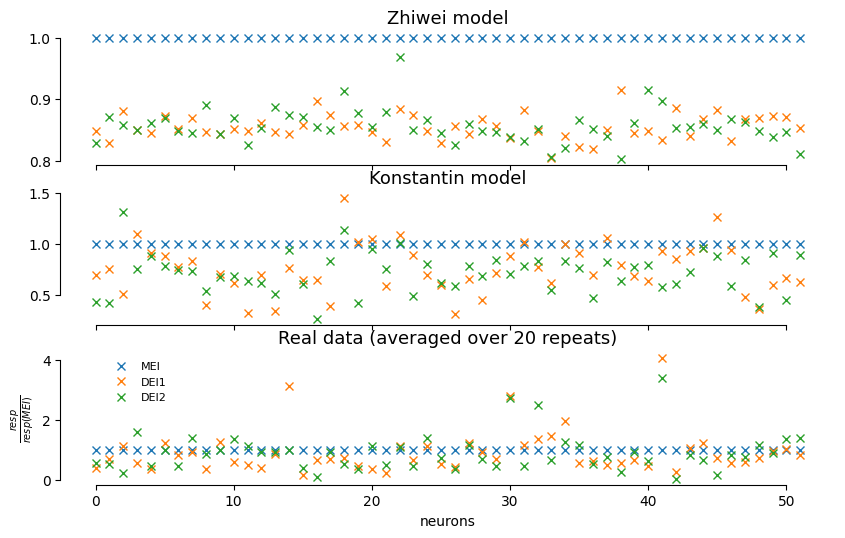

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), dpi=100, sharex=True)
fontsize = 10


y_zhiwei = e / e[0, :]
y_konstantin = zig_means / zig_means[0, :]
y_konstantin = y_konstantin[:, keep_idx]
y_real = real_resp_means / real_resp_means[0, :]
y_real = y_real[:, keep_idx]
x = np.arange(y_real.shape[1])

# Zhiwei
for i in range(3):
    axes[0].plot(x, y_zhiwei[i,:], ls="", marker="x")

# Konstantin
for i in range(3):
    axes[1].plot(x, y_konstantin[i,:], ls="", marker="x")
    
# Real data
for i, label in enumerate(["MEI", "DEI1", "DEI2"]):
    axes[2].plot(x, y_real[i,:], ls="", marker="x", label=label)
    
    
axes[0].set_title("Zhiwei model", fontsize=fontsize*1.3)
axes[1].set_title("Konstantin model", fontsize=fontsize*1.3)
axes[2].set_title("Real data (averaged over 20 repeats)", fontsize=fontsize*1.3)
axes[2].set_xlabel("neurons", fontsize=fontsize)
axes[2].set_ylabel(r"$\frac{resp}{resp(MEI)}$", fontsize=fontsize)

# axes[1].set(ylim=[0, 6])

axes[2].legend(bbox_to_anchor=(0.15, 1., 0, 0), frameon=False, fontsize=fontsize*.8)
sns.despine(trim=True)
# fig.savefig("Zhiwei_Model_Comparison" + ".png", bbox_inches="tight", transparent=False)

In [26]:
idx = np.argsort(np.abs(y_konstantin[1] - y_konstantin[2]))

In [40]:
sorted_mean = zig_means[:, keep_idx][:, idx]
sorted_var = zig_variances[:, keep_idx][:, idx]

sorted_real_means = real_resp_means[:, keep_idx][:, idx]
sorted_real_vars = real_resp_vars[:, keep_idx][:, idx]

In [37]:
np.abs(sorted_var[1] - sorted_var[2])/ np.abs(sorted_mean[1] - sorted_mean[2]) * 2

array([87.88958923, 25.12521628, 44.30197436, 30.86910402, 18.09632401,
        3.54920497,  4.73065765,  6.89497791, 53.05381   , 26.89746226,
       23.59706398, 19.45465955, 26.53927014,  9.06056877,  0.29799623,
        2.23044483,  9.62052789, 13.58018255, 11.788277  , 31.45307882,
        6.14386201,  8.50411285, 11.98386493, 12.43876206, 21.61585989,
       11.37611656, 29.98648818, 29.03636948,  2.38267786, 16.35062446,
       33.26092099, 15.73512339,  8.17925869, 25.81171958,  8.75764519,
       14.86583546,  5.48707466,  6.25377764,  9.55648501, 19.64530405,
       25.90381827, 11.35886402, 20.6338463 , 23.13132248, 30.43840822,
        9.03833758, 10.56171695, 16.81181182, 23.80810693, 11.29430404,
       12.40696444, 13.86556506])

In [42]:
sorted_real_vars[1:, idx[:5]]

array([[ 7.52290487, 40.60706329, 13.7837162 , 54.48014069, 27.04310226],
       [11.29517555, 14.54772758, 12.29416466, 65.64176941, 28.27656937]])

In [43]:
sorted_var[1:, idx[:5]]

array([[12.54012489, 39.61982727,  6.62738132, 13.14911652,  6.37679863],
       [37.64199066, 16.69067192,  4.77531481, 12.92468739,  5.88129234]])

___

In [57]:
i = 0
j = 1
threshold = .1

norm_diff = (zig_means[i] - zig_means[j]) / (zig_means[i] + zig_means[j]) * 2 
neuron_idx = np.where(norm_diff <= threshold)[0]

zig_means[[i, j], :][:, neuron_idx]

array([[4.43239498, 1.74529767, 2.27520561, 1.62336516, 3.22774482,
        3.54734993, 2.35890245, 4.605793  , 1.22405756, 3.84729052,
        1.93736982, 0.93584168, 1.85969234, 2.6175108 , 2.52116132,
        5.23227692, 1.40527153, 1.21182358],
       [4.83494425, 1.59264362, 2.27755356, 2.35494471, 3.08908868,
        3.60139561, 2.45786548, 4.6411953 , 1.32676363, 3.89562297,
        1.94055188, 0.85056108, 1.96953034, 2.42282677, 2.33351851,
        4.99696112, 1.77443862, 1.14214122]])

___

# Correlation Analysis across [MEI, DEI, DEI]

## Mean

### Spearman Rank Correlation

In [18]:
cs_ks, cs_zs = [], []
for i in range(e.shape[-1]):
    cs_k, p = spearmanr(real_resp_means[:, keep_idx][:, i], zig_means[:, keep_idx][:, i], axis=0)
    cs_z, p = spearmanr(real_resp_means[:, keep_idx][:, i], e[:, i], axis=0)
    cs_ks.append(cs_k)
    cs_zs.append(cs_z)

In [19]:
np.mean(cs_ks), np.mean(cs_zs)

(0.2980769230769231, 0.2980769230769231)

### Pearson Correlation

In [20]:
cp_k = np.mean(corr(real_resp_means[:, keep_idx], zig_means[:, keep_idx], axis=0))
cp_z = np.mean(corr(real_resp_means[:, keep_idx], e, axis=0))

In [21]:
cp_k, cp_z

(0.2730772573220369, 0.34435400489966467)

In [20]:
cp_ks, cp_zs = [], []
for i in range(e.shape[-1]):
    cp_k, p = pearsonr(real_resp_means[:, keep_idx][:, i], zig_means[:, keep_idx][:, i])
    cp_z, p = pearsonr(real_resp_means[:, keep_idx][:, i], e[:, i])
    cp_ks.append(cp_k)
    cp_zs.append(cp_z)

In [22]:
np.mean(cp_ks), np.mean(cp_zs)

(0.34786196559469984, 0.3443540155522746)

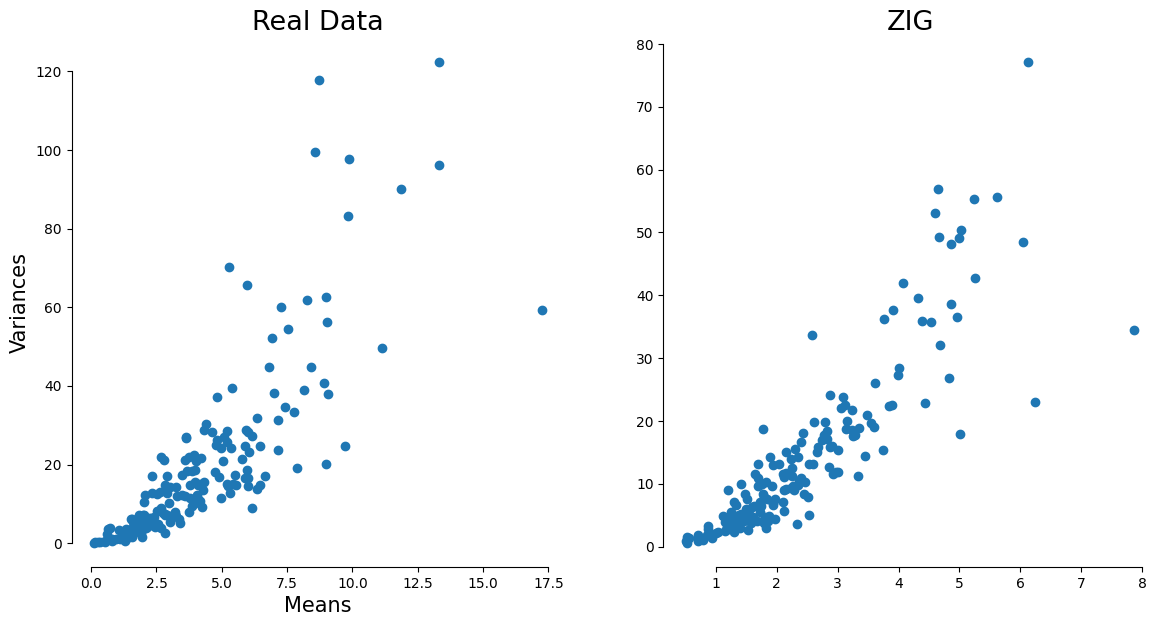

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

fontsize = 15

axes[0].scatter(real_resp_means.flatten(), real_resp_vars.flatten())
axes[0].set_xlabel("Means", fontsize=fontsize)
axes[0].set_ylabel("Variances", fontsize=fontsize)
axes[0].set_title("Real Data", fontsize=fontsize*1.3)

axes[1].scatter(zig_means.flatten(), zig_variances.flatten())
axes[1].set_title("ZIG", fontsize=fontsize*1.3)
# axes[1].set(xlim=[0, 15], ylim=[0, 400])

sns.despine(trim=True)

In [ ]:
np.where(variances == variances[:, keep_idx].max())

In [ ]:
variances[:, keep_idx][:, 5]

In [ ]:
variances.shape